In [1]:
from utils.configuration import get_config_from_json
from utils.training_utilities import set_GPU
from utils.plotting_traces import plot_traces
from seq2point.seq2point import SEQ2POINT
from dataset_management.dataloader import Seq2PointDataLoader
import builtins

In [2]:
builtins.MODEL_CONFIG = get_config_from_json(description="Model Parameters", config_file="configs/model_config.json")
builtins.DATASET_CONFIG = get_config_from_json(description="Dataset Management", config_file="configs/dataset_config.json")
builtins.PLOT_CONFIG = get_config_from_json(description="Plot Settings", config_file="configs/plot_config.json")
builtins.TRAINING_CONFIG = get_config_from_json(description="Training Configuration", config_file="configs/training_config.json")

In [3]:
TRAINING_CONFIG['EXPERIMENT_PATH'] = f'experiments/{TRAINING_CONFIG["TARGET_APPLIANCE"]}/{TRAINING_CONFIG["TARGET_HOUSES"]["TRAIN"]}/'

In [4]:
dataloaders = Seq2PointDataLoader(
    target_appliance=TRAINING_CONFIG['TARGET_APPLIANCE'], 
    target_houses= TRAINING_CONFIG['TARGET_HOUSES'], 
    proportion = TRAINING_CONFIG['SPLIT_PROPORTION'], 
    subset_days = TRAINING_CONFIG['SUBSET_DAYS'],
    scalers_directory = TRAINING_CONFIG['EXPERIMENT_PATH'],
    # normalize_with=TRAINING_CONFIG['NORMALIZE']
)

Followings are the refit_loader configuration 
{'DATA_FOLDER': 'data/refit/', 'DATA_TYPE': '.csv', 'README_FILE': 'refit_loader/REFIT_Readme.txt', 'REFIT_HOUSES': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21]}

Loading specified buildings: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21]
Parsing the readme file specified: refit_loader/REFIT_Readme.txt
Loading data for appliance KETTLE ...
Fetching KETTLE data for House 2
Resampling for house number:  2
Updating data with resampled dataset...
Subetting dataset with 1 days of most activities for House 2
Estimating active durations of: kettle
Updating data with selected active appliance activities...
Updating splits with specified proportion from every target house...
Normalization is being performed for training a model. Scalers will be computed/fit considering the train_split and using those scalers, all splits will be normalized/transformed.
Updating splits with normalized data splits...

In [5]:
network = SEQ2POINT().to(set_GPU())
results = network.run(dataloaders.train_dataloader, dataloaders.validation_dataloader, assess_training=True)


Initializing SEQ2POINT model archiecture

Followings are the Model Parameters of your network architecture..
{'CONV_KERNEL': [10, 8, 6, 5, 5],
 'CONV_LAYERS': 5,
 'CONV_PADDING': 0,
 'CONV_STRIDE': 1,
 'DESCRIPTION': 'Model Parameters',
 'INPUT_CHANNELS': [1, 30, 30, 40, 50],
 'LEFT_PAD': [4, 3, 2, 2, 2],
 'LINEAR_INPUT': [29950, 1024],
 'LINEAR_LAYERS': 2,
 'LINEAR_OUTPUT': [1024, 1],
 'OUTPUT_CHANNELS': [30, 30, 40, 50, 50],
 'POOL_KERNEL': [],
 'POOL_STRIDE': [],
 'RIGHT_PAD': [5, 4, 3, 2, 2],
 'SEQUENCE_LENGTH': 599}

SEQ2POINT model archiecture has been initialized.


Followings are the Training Configuration of your experiment..
{'DESCRIPTION': 'Training Configuration',
 'EARLY_STOPPING_THRESHOLD': 5,
 'EXPERIMENT_PATH': 'experiments/KETTLE/[2]/',
 'LEARNING_RATE': 0.0001,
 'LOSS': 'nn.MSELoss',
 'LOSS_REDUCTION': 'mean',
 'NORMALIZE': 'Standard',
 'NUM_EPOCHS': 2,
 'OPTIMIZER': 'optim.Adam',
 'PRE_TRAINED_MODEL_FLAG': False,
 'SPLIT_PROPORTION': {'TEST_PERCENT': 0.2,
          


Followings are the Plot Settings of your project..
{'COLORS': ['dodgerblue',
            'coral',
            'mediumpurple',
            'lightseagreen',
            'peru',
            'hotpink',
            'teal',
            'orange'],
 'DESCRIPTION': 'Plot Settings',
 'FIG_XSIZE': 14.0,
 'FIG_YSIZE': 6.0,
 'FONT_SIZE': 12.0,
 'LATEX': False,
 'LEGEND_FONT_SIZE': 11.0,
 'LEGEND_HANDLE': 5.0,
 'LEGEND_LOCATION': 'upper right',
 'MAJOR_TICKS': 5.0,
 'MARKER': 'o',
 'MINOR_TICKS': 3.0,
 'OPACITY': 0.7,
 'STYLE': 'default',
 'TICK_DIRECTION': 'out'}
Error occured in plot_traces method due to  'NoneType' object is not iterable


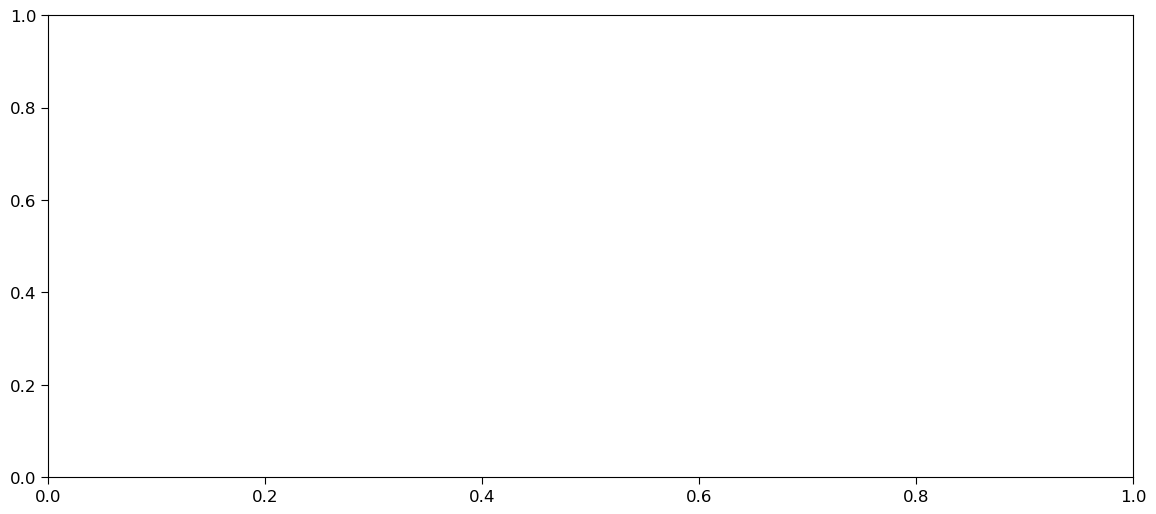

In [6]:
plot_traces(traces=results, labels = ['training loss', 'validation loss'], axis_labels=['Epoch', 'Loss Score'] )

In [ ]:
test_network = SEQ2POINT().to(set_GPU())

In [ ]:
test_network.inference(dataloaders.test_dataloader)